In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import sys
import os
import subprocess
from six import string_types
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
!ls -lha ../input

total 12K
drwxr-xr-x 3 root   root    4.0K Sep 20 13:04 .
drwxr-xr-x 5 root   root    4.0K Sep 20 13:04 ..
drwxr-xr-x 4 nobody nogroup 4.0K Jul 20 20:57 planets-dataset


In [6]:
train_data = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
train_data.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
!ls ../input/planets-dataset/planet/planet/train-jpg | wc -l

40479


In [8]:
sample_submission_data = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission_data.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [9]:
# Build list with unique labels
label_list = []
for tag_str in train_data.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
            
label_list

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [10]:
label_list = set()
def append_labels(tags):
    for tag in tags.split():
        label_list.add(tag)

train_data_df = train_data.copy()
train_data_df['tags'].apply(append_labels)
label_list = list(label_list)
print(label_list)

['agriculture', 'conventional_mine', 'cultivation', 'cloudy', 'habitation', 'bare_ground', 'water', 'primary', 'partly_cloudy', 'blooming', 'blow_down', 'selective_logging', 'haze', 'slash_burn', 'artisinal_mine', 'clear', 'road']


In [11]:
# one hot encoding every label
for label in label_list:
    train_data[label] = train_data['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    
train_data['image_name'] = train_data['image_name'].apply(lambda x: '{}.jpg'.format(x)) 

# Display head
train_data.head()

,image_name,tags,agriculture,conventional_mine,cultivation,cloudy,habitation,bare_ground,water,primary,partly_cloudy,blooming,blow_down,selective_logging,haze,slash_burn,artisinal_mine,clear,road
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
2,train_2.jpg,clear primary,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,train_3.jpg,clear primary,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1


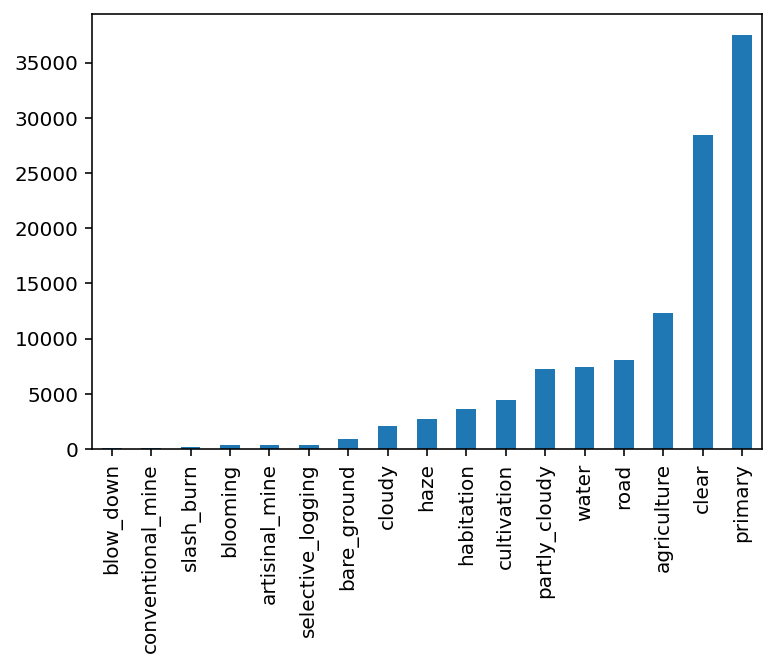

In [12]:
# visualizing data
train_data[label_list].sum().sort_values().plot.bar()

In [13]:
image_number =10
img = io.imread('../input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(image_number))
img.shape

(256, 256, 3)

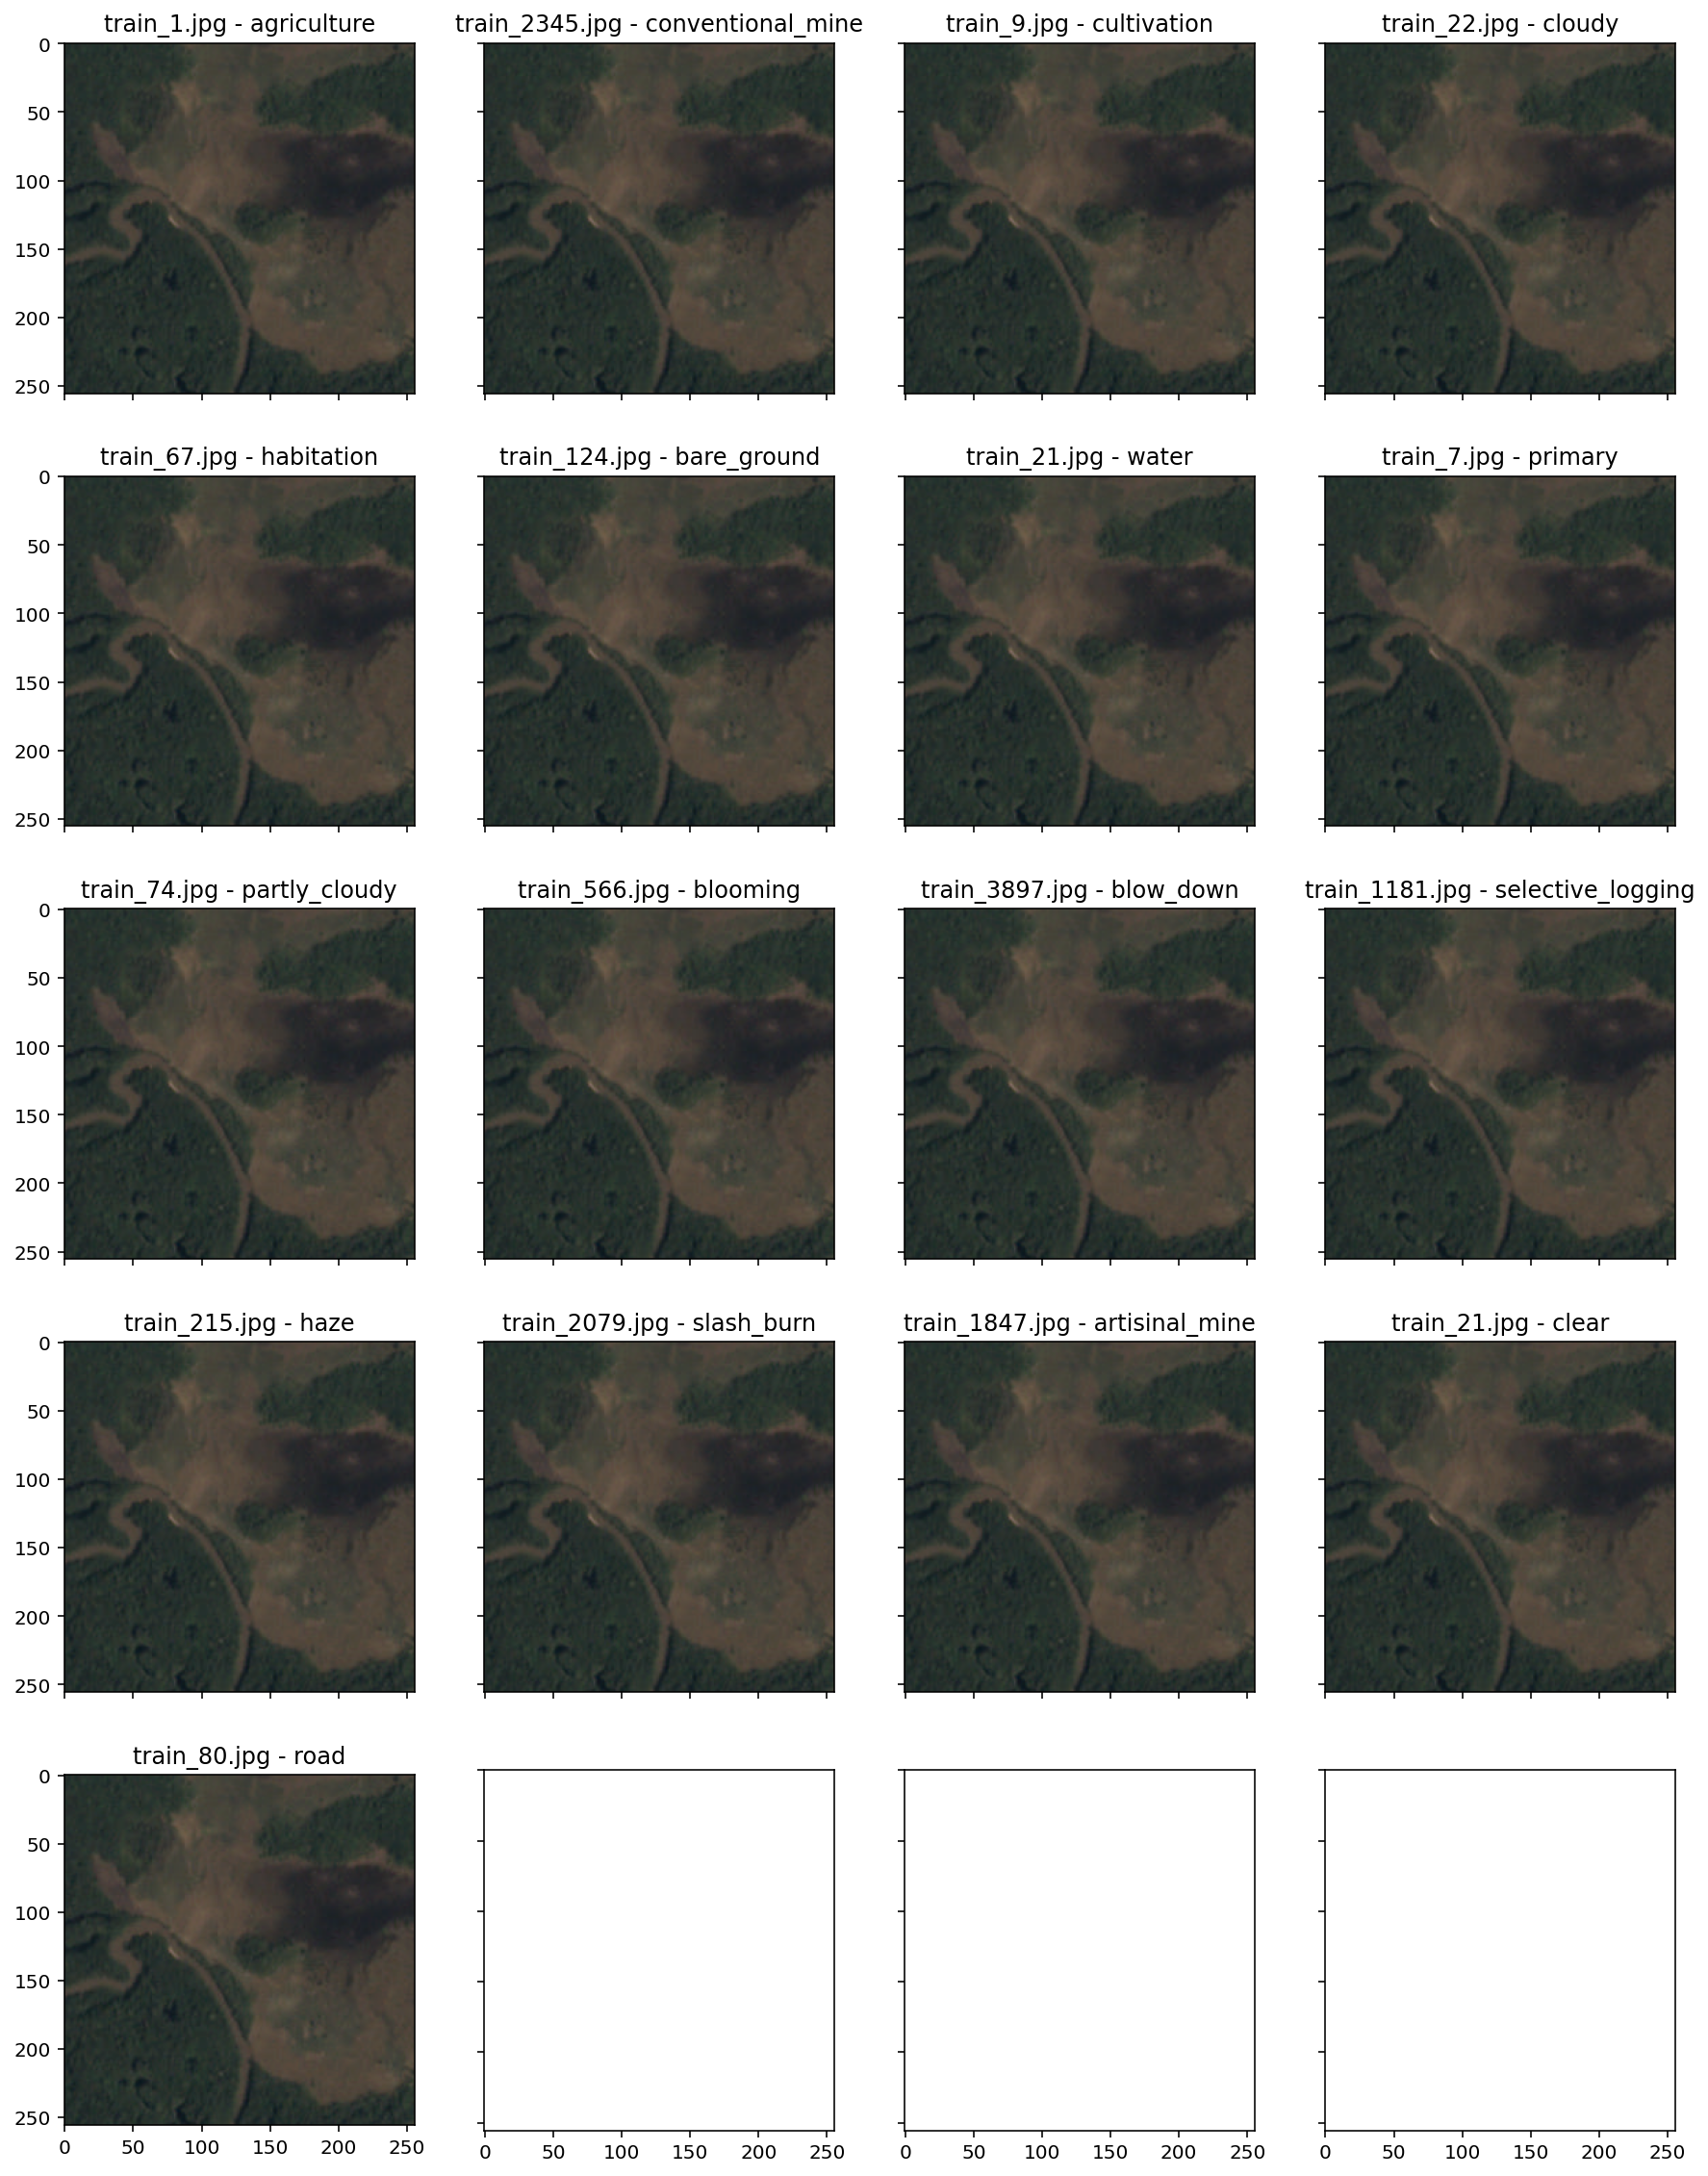

In [14]:
images_title = [train_data[train_data['tags'].str.contains(label)].iloc[i]['image_name']
                for i, label in enumerate(label_list)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, label_list)):
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

In [15]:
tf.__version__

'2.2.0'

In [16]:
train_data.head()

,image_name,tags,agriculture,conventional_mine,cultivation,cloudy,habitation,bare_ground,water,primary,partly_cloudy,blooming,blow_down,selective_logging,haze,slash_burn,artisinal_mine,clear,road
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
2,train_2.jpg,clear primary,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,train_3.jpg,clear primary,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1


In [17]:
y_col = list(train_data.columns[2:]) 

# loading images
X = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=train_data, 
                               directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', 
                              y_col=y_col, target_size=(128, 128), class_mode='raw', seed=1, batch_size=128)



Found 40479 validated image filenames.


In [18]:
# first batch
x = X[0][0][109]

# first batch
y = X[0][1][109] 
print("each image's shape is {}".format(x.shape))
print("each label's shape is {}".format(y.shape))
print('we have {} batches'.format(len(X)))
print('each batch has {} images/labels'.format(X[0][0].shape[0]))

each image's shape is (128, 128, 3)
each label's shape is (17,)
we have 317 batches
each batch has 128 images/labels


In [19]:
def fbeta(ytrue , ypred, beta=2, epsilon=1e-4):
    beta_squarred = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squarred)*precision*recall / (beta_squarred*precision + recall + epsilon)
    return fb

In [20]:
def multi_label_acc(ytrue , ypred, epsilon=1e-4):
    
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(ytrue), tf.float32) * tf.cast(tf.logical_not(ypred), tf.float32),\
                       axis=1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

In [21]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=3, input_shape=(128, 128, 3)))
    model.add(Flatten())
    model.add(Dense(17, activation='sigmoid'))
    opt = Adam(lr=1e-2)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[multi_label_acc, fbeta])
    
    return model

In [22]:
save_best_check_point = ModelCheckpoint(filepath='best_model.hdf5', monitor='val_fbeta',
                                        mode='max', save_best_only=True, save_weights_only=True)

In [23]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

# generating the 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_data,
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col,
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='training')

# generating the 20% validation image data
val_gen = train_image_gen.flow_from_dataframe(dataframe=train_data,
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col,
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [24]:
# setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [25]:
step_train_size+step_val_size

317

In [26]:
model1 = build_model() 
# building a sequential model for training

# fitting the model
model1.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=2, callbacks=[save_best_check_point])

Epoch 1/2
253/253 [==============================] - 123s 485ms/step - loss: 46.3698 - multi_label_acc: 0.8540 - fbeta: 0.5994 - val_loss: 1.3484 - val_multi_label_acc: 0.8820 - val_fbeta: 0.5474
Epoch 2/2
253/253 [==============================] - 103s 408ms/step - loss: 19.8940 - multi_label_acc: 0.8569 - fbeta: 0.6015 - val_loss: 46.1228 - val_multi_label_acc: 0.8987 - val_fbeta: 0.6353


In [27]:
# Improving my model with VGG16
from keras.applications.vgg16 import VGG16
model = VGG16()
model = VGG16(weights="imagenet", include_top=False,input_shape=(128, 128, 3))
print(model.summary())

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

In [28]:

history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='weights/weights.best.hdf5', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto')]


model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])


In [111]:
# fitting the model
model.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=2, callbacks=[save_best_check_point])

In [29]:
model2 = build_model()

model2.load_weights('best_model.hdf5')

In [30]:
sample_submission = sample_submission_data.copy()
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [31]:
test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [32]:
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df,
            directory='../input/planets-dataset/planet/planet/test-jpg/', x_col='image_name', y_col=None,
            batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

Found 40669 validated image filenames.


In [33]:
test_gen1.reset() 
pred1 = model2.predict(test_gen1, steps=step_test_size1, verbose=1) 

318/318 [==============================] - 137s 432ms/step


In [34]:
test_file_names1 = test_gen1.filenames 
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(label_list)[x > 0.5]), axis=1)

result1 = pd.DataFrame({'image_name': test_file_names1, 'tags': pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,primary
1,test_1.jpg,primary clear
2,test_2.jpg,agriculture primary
3,test_3.jpg,primary clear
4,test_4.jpg,agriculture primary road


In [35]:
test2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [36]:
test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df,
            directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional/', x_col='image_name',
            y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

step_test_size2 = int(np.ceil(test_gen2.samples / test_gen2.batch_size))

Found 20522 validated image filenames.


In [37]:
test_gen2.reset()
pred2 = model2.predict(test_gen2, steps=step_test_size2, verbose=1) 

161/161 [==============================] - 61s 377ms/step


In [38]:
test_file_names2 = test_gen2.filenames 
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ' '.join(np.array(label_list)[x > 0.5]), axis=1)

result2 = pd.DataFrame({'image_name': test_file_names2, 'tags': pred_tags2})
result2.head()

,image_name,tags
0,file_0.jpg,primary clear
1,file_1.jpg,agriculture primary clear road
2,file_10.jpg,agriculture primary road
3,file_100.jpg,primary
4,file_1000.jpg,primary clear


In [39]:
final_result = pd.concat([result1, result2]) 
final_result = final_result.reset_index().drop('index', axis=1) 
print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,primary
1,test_1.jpg,primary clear
2,test_2.jpg,agriculture primary
3,test_3.jpg,primary clear
4,test_4.jpg,agriculture primary road


In [40]:
assert sum(sample_submission['image_name'] == final_result['image_name']) == 61191

In [41]:
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()

,image_name,tags
0,test_0,primary
1,test_1,primary clear
2,test_2,agriculture primary
3,test_3,primary clear
4,test_4,agriculture primary road


In [45]:
final_result.to_csv('fifth_submission.csv', index=False)